# 08-VGG

[1. The Oxford-IIIT Pet Dataset](#1)  

[2. Data Preprocessing](#2)  
 - [2-1.Compute Mean, Std of Training Set](#2-1)
 - [2-2.Define Torch Dataset](#2-2)

[3.Define VGG19](#3)

[4.Training](#4)
 - [4-1.Hyper Parameters](#4-1)
 - [4-2.Torch DataLoader](#4-2)
 - [4-3.Train function](#4-3)
 - [4-4.Valid function](#4-4)
 - [4-5.Train Loop](#4-5)

In [1]:
import os
import cv2
import torch
import numpy as np
import albumentations as A
import matplotlib.pyplot as plt

from torch import nn
from tqdm import tqdm
from torchsummary import summary
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

<a id="1"></a>
## 1. 100 Sports Image Classification
[https://www.kaggle.com/datasets/gpiosenka/sports-classification/data](https://www.kaggle.com/datasets/gpiosenka/sports-classification/data)

In [2]:
data_dir = "/home/pervinco/Datasets/mammals-classification/data"
classes = sorted(os.listdir(data_dir))
print(classes)

['african_elephant', 'alpaca', 'american_bison', 'anteater', 'arctic_fox', 'armadillo', 'baboon', 'badger', 'blue_whale', 'brown_bear', 'camel', 'dolphin', 'giraffe', 'groundhog', 'highland_cattle', 'horse', 'jackal', 'kangaroo', 'koala', 'manatee', 'mongoose', 'mountain_goat', 'opossum', 'orangutan', 'otter', 'polar_bear', 'porcupine', 'red_panda', 'rhinoceros', 'sea_lion', 'seal', 'snow_leopard', 'squirrel', 'sugar_glider', 'tapir', 'vampire_bat', 'vicuna', 'walrus', 'warthog', 'water_buffalo', 'weasel', 'wildebeest', 'wombat', 'yak', 'zebra']


In [3]:
images, labels = [], []
for str_label in classes:
    img_files = os.listdir(f"{data_dir}/{str_label}")
    for file in img_files:
        if file.endswith(".jpg"):
            images.append(f"{data_dir}/{str_label}/{file}")
            labels.append(str_label)

print(f"Num of Classes : {len(classes)}")
print(f"Num of files & labels : {len(images)}, {len(labels)}")
print(images[0])

Num of Classes : 45
Num of files & labels : 13751, 13751
/home/pervinco/Datasets/mammals-classification/data/african_elephant/african_elephant-0125.jpg


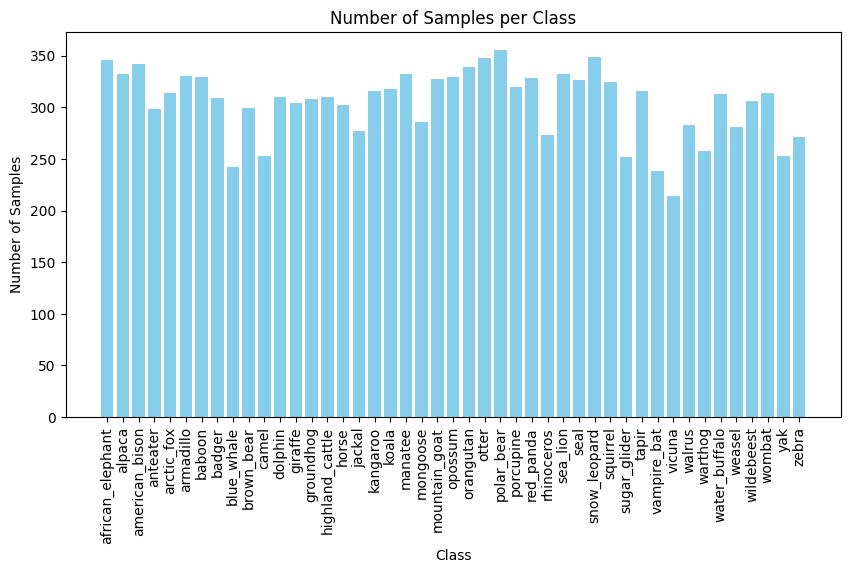

In [4]:
classes = list(classes)
sample_per_class = {}
for label in labels:
    if not label in sample_per_class:
        sample_per_class[label] = 0
    else:
        sample_per_class[label] += 1

plt.figure(figsize=(10, 5))
plt.bar(sample_per_class.keys(), sample_per_class.values(), color='skyblue')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Number of Samples per Class')
plt.xticks(rotation=90)
plt.show()

<a id="2"></a>
## 2. Data Preprocessing

In [5]:
train_x, valid_x, train_y, valid_y = train_test_split(images, labels, test_size=0.1, shuffle=True, random_state=42)

print(len(train_x), len(train_y))
print(len(valid_x), len(valid_y))

12375 12375
1376 1376


<a id="2-1"></a>
### 2-1.Compute Mean, Std of Training Set

In [6]:
# def compute_mean_std(files):
#     images = np.zeros((len(files), 224, 224, 3), dtype=np.uint8)
#     for idx, file in enumerate(files):
#         image = cv2.imread(file)
#         image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#         image = cv2.resize(image, (224, 224))
#         images[idx, :, : ,:] = image
    
#     mean_rgb = np.mean(images, axis=(0, 1, 2))
#     std_rgb = np.std(images, axis=(0, 1, 2))

#     return mean_rgb, std_rgb

# mean, std = compute_mean_std(train_x)
# print(mean, std)

<a id="2-2"></a>
### 2-2.Define Torch Dataset

In [7]:
class PetDataset(Dataset):
    def __init__(self, images, labels, classes, mean=None, std=None, augmentation=False):
        self.classes = classes
        self.images = images
        self.labels = labels

        if mean is None:
            mean = (0.485, 0.456, 0.406)

        if std is None:
            std = (0.229, 0.224, 0.225)

        if augmentation:
            self.augmentation = A.Compose([
                A.OneOf([
                    A.Resize(224, 224, p=0.5),
                    A.SmallestMaxSize(max_size=[256, 512], p=0.5)
                ], p=1),
                A.RandomCrop(width=224, height=224),
                A.HorizontalFlip(),
                A.RGBShift(),
                A.Normalize(mean=mean, std=std),
                ToTensorV2()
            ])
        else:
            self.augmentation = A.Compose([
                A.Resize(224, 224, p=1),
                A.Normalize(mean=mean, std=std),
                ToTensorV2()
            ])


    def __len__(self):
        return len(self.images)


    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        image = cv2.imread(image)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label = self.classes.index(label)

        image = self.augmentation(image=image)["image"]

        return image, label

In [8]:
train_dataset = PetDataset(train_x, train_y, classes, augmentation=True)
valid_dataset = PetDataset(valid_x, valid_y, classes, augmentation=False)

In [9]:
sample_image, sample_label = train_dataset[0]
print(sample_image.shape, sample_label)

torch.Size([3, 224, 224]) 3


<a id="3"></a>
## 3. Define VGG19

In [10]:
def conv_bn_act(in_channels, out_channels, num_layers, linear_projection=False):
    block = []
    for idx in range(num_layers):
        if idx > 0:
            in_channels = out_channels

        if idx == num_layers - 1 and linear_projection:
            conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, padding=1, stride=1)

        else:
            conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=1)  
            
        block.extend([conv,
                      nn.BatchNorm2d(out_channels),
                      nn.ReLU(inplace=True)])

    block.extend([nn.MaxPool2d(kernel_size=2, stride=2)])

    return nn.Sequential(*block)

In [11]:
class VGG(nn.Module):
    def __init__(self, num_classes, model_name="vgg16", linear_projection=False, drop_rate=0.5, init_weights=False):
        super().__init__()
        vgg_configs = {"vgg11" : [1, 1, 2, 2, 2],
                       "vgg13" : [2, 2, 2, 2, 2],
                       "vgg16" : [2, 2, 3, 3, 3],
                       "vgg19" : [2, 2, 4, 4, 4]}

        config = vgg_configs[model_name]
        self.block1 = conv_bn_act(in_channels=3, out_channels=64, num_layers=config[0])
        self.block2 = conv_bn_act(in_channels=64, out_channels=128, num_layers=config[1])
        self.block3 = conv_bn_act(in_channels=128, out_channels=256, num_layers=config[2], linear_projection=linear_projection)
        self.block4 = conv_bn_act(in_channels=256, out_channels=512, num_layers=config[3], linear_projection=linear_projection)
        self.block5 = conv_bn_act(in_channels=512, out_channels=512, num_layers=config[4], linear_projection=linear_projection)

        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(nn.Linear(512 * 7 * 7, 4096),
                                        nn.ReLU(inplace=True),
                                        nn.Dropout(drop_rate),
                                        nn.Linear(4096, 4096),
                                        nn.ReLU(inplace=True),
                                        nn.Dropout(drop_rate),
                                        nn.Linear(4096, num_classes))
        
        if init_weights:
            for m in self.modules():
                if isinstance(m, nn.Conv2d):
                    nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
                    if m.bias is not None:
                        nn.init.constant_(m.bias, 0)
                    elif isinstance(m, nn.BatchNorm2d):
                        nn.init.constant_(m.weight, 1)
                        nn.init.constant_(m.bias, 0)
                    elif isinstance(m, nn.Linear):
                        nn.init.normal_(m.weight, 0, 0.01)
                        nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1) ## [512, 7, 7] to 25088

        x = self.classifier(x)

        return x

In [12]:
## 모델이 제대로 만들어졌는지 검증.

model = VGG(len(classes), model_name="vgg16", init_weights=True)
dummy_input = torch.randn(1, 3, 224, 224)
output = model(dummy_input)

<a id="4"></a>
## 4.Training

<a id="4-1"></a>
### 4-1.Hyper Parameters

In [13]:
epochs = 300
batch_size = 64
learning_rate = 0.0001
weight_decay = 0.09
momentum = 0.9

num_workers = os.cpu_count()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

<a id="4-2"></a>
### 4-2. Torch DataLoader

In [14]:
train_dataloder = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, num_workers=num_workers)

### 4-3.Train function

In [15]:
def train(model, dataloader, criterion, optimizer, device):
    model.train()

    train_cost, train_acc = 0.0, 0.0
    for x, y in tqdm(dataloader, desc="Train", leave=False):
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        y_pred = model(x)

        cost = criterion(y_pred, y)
        cost.backward()
        optimizer.step()

        train_cost += cost.item() * x.size(0)

        _, pred_labels = torch.max(y_pred, 1)
        train_acc += (pred_labels == y).sum().item()

    train_cost /= len(dataloader.dataset)
    train_acc /= len(dataloader.dataset)

    return train_cost, train_acc

<a id="4-4"></a>
### 4-4.Valid function

In [16]:
def valid(model, dataloader, criterion, device):
    model.eval()

    valid_cost, valid_acc = 0.0, 0.0
    with torch.no_grad():
        for x, y in tqdm(dataloader, desc="Valid", leave=False):
            x, y = x.to(device), y.to(device)
            y_pred = model(x)

            cost = criterion(y_pred, y)

            valid_cost += cost.item() * x.size(0)

            _, pred_labels = torch.max(y_pred, 1)
            valid_acc += (pred_labels == y).sum().item()

        valid_cost /= len(dataloader.dataset)
        valid_acc /= len(dataloader.dataset)

    return valid_cost, valid_acc

<a id="4-5"></a>
### 4-5.Train Loop

In [17]:
model = VGG(len(classes), model_name="vgg16", init_weights=True)
summary(model, input_size=(3, 224, 224), device="cpu")

model = model.to(device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
       BatchNorm2d-2         [-1, 64, 224, 224]             128
              ReLU-3         [-1, 64, 224, 224]               0
            Conv2d-4         [-1, 64, 224, 224]          36,928
       BatchNorm2d-5         [-1, 64, 224, 224]             128
              ReLU-6         [-1, 64, 224, 224]               0
         MaxPool2d-7         [-1, 64, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]          73,856
       BatchNorm2d-9        [-1, 128, 112, 112]             256
             ReLU-10        [-1, 128, 112, 112]               0
           Conv2d-11        [-1, 128, 112, 112]         147,584
      BatchNorm2d-12        [-1, 128, 112, 112]             256
             ReLU-13        [-1, 128, 112, 112]               0
        MaxPool2d-14          [-1, 128,

In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)

In [19]:
for epoch in range(epochs):
    train_cost, train_acc = train(model, train_dataloder, criterion, optimizer, device)
    valid_cost, valid_acc = valid(model, valid_dataloader, criterion, device)

    if epoch % 10 == 0:
        print(f"Epoch : {epoch} | {epochs}")
        print(f"\tTrain Loss : {train_cost:.4f}, Train Acc : {train_acc:.4f}")
        print(f"\tValid Loss : {valid_cost:.4f}, Valid Acc : {valid_acc:.4f}")

Epoch : 0 | 300
	Train Loss : 3.8030, Train Acc : 0.0314
	Valid Loss : 3.7727, Valid Acc : 0.0240


Epoch : 10 | 300
	Train Loss : 3.4990, Train Acc : 0.1062
	Valid Loss : 3.4248, Valid Acc : 0.1330


Epoch : 20 | 300
	Train Loss : 3.2895, Train Acc : 0.1455
	Valid Loss : 3.1801, Valid Acc : 0.1802


Epoch : 30 | 300
	Train Loss : 3.1097, Train Acc : 0.1839
	Valid Loss : 2.9902, Valid Acc : 0.2369


Epoch : 40 | 300
	Train Loss : 2.9401, Train Acc : 0.2166
	Valid Loss : 2.8175, Valid Acc : 0.2456


Epoch : 50 | 300
	Train Loss : 2.7911, Train Acc : 0.2482
	Valid Loss : 2.6823, Valid Acc : 0.2718


Epoch : 60 | 300
	Train Loss : 2.6417, Train Acc : 0.2823
	Valid Loss : 2.5818, Valid Acc : 0.2624


Epoch : 70 | 300
	Train Loss : 2.5058, Train Acc : 0.3182
	Valid Loss : 2.4187, Valid Acc : 0.3561


Epoch : 80 | 300
	Train Loss : 2.3784, Train Acc : 0.3552
	Valid Loss : 2.3986, Valid Acc : 0.3190


Epoch : 90 | 300
	Train Loss : 2.2323, Train Acc : 0.3970
	Valid Loss : 2.3038, Valid Acc : 0.3532


Epoch : 100 | 300
	Train Loss : 2.0645, Train Acc : 0.4523
	Valid Loss : 2.1532, Valid Acc : 0.4084


Epoch : 110 | 300
	Train Loss : 1.9208, Train Acc : 0.4936
	Valid Loss : 2.2501, Valid Acc : 0.3394


Epoch : 120 | 300
	Train Loss : 1.7504, Train Acc : 0.5403
	Valid Loss : 2.0551, Valid Acc : 0.4251


Epoch : 130 | 300
	Train Loss : 1.5958, Train Acc : 0.5901
	Valid Loss : 1.8646, Valid Acc : 0.4840


Epoch : 140 | 300
	Train Loss : 1.4654, Train Acc : 0.6368
	Valid Loss : 2.0429, Valid Acc : 0.4477


Epoch : 150 | 300
	Train Loss : 1.3728, Train Acc : 0.6718
	Valid Loss : 1.6238, Valid Acc : 0.5712


Epoch : 160 | 300
	Train Loss : 1.2292, Train Acc : 0.7199
	Valid Loss : 1.6674, Valid Acc : 0.5254


Epoch : 170 | 300
	Train Loss : 1.1048, Train Acc : 0.7611
	Valid Loss : 1.2385, Valid Acc : 0.6744


Epoch : 180 | 300
	Train Loss : 1.0331, Train Acc : 0.7827
	Valid Loss : 1.2984, Valid Acc : 0.6621


Epoch : 190 | 300
	Train Loss : 0.9590, Train Acc : 0.8027
	Valid Loss : 1.3914, Valid Acc : 0.6410


Epoch : 200 | 300
	Train Loss : 0.9347, Train Acc : 0.8112
	Valid Loss : 1.3964, Valid Acc : 0.6461


Epoch : 210 | 300
	Train Loss : 0.9044, Train Acc : 0.8177
	Valid Loss : 1.3821, Valid Acc : 0.6403


Epoch : 220 | 300
	Train Loss : 0.8830, Train Acc : 0.8259
	Valid Loss : 1.1196, Valid Acc : 0.7376


Epoch : 230 | 300
	Train Loss : 0.8570, Train Acc : 0.8346
	Valid Loss : 1.0782, Valid Acc : 0.7427


Epoch : 240 | 300
	Train Loss : 0.8494, Train Acc : 0.8373
	Valid Loss : 1.1654, Valid Acc : 0.7093


Epoch : 250 | 300
	Train Loss : 0.8164, Train Acc : 0.8459
	Valid Loss : 1.0591, Valid Acc : 0.7297


Epoch : 260 | 300
	Train Loss : 0.8066, Train Acc : 0.8478
	Valid Loss : 1.0137, Valid Acc : 0.7536


Epoch : 270 | 300
	Train Loss : 0.8079, Train Acc : 0.8469
	Valid Loss : 1.0691, Valid Acc : 0.7471


Epoch : 280 | 300
	Train Loss : 0.7861, Train Acc : 0.8522
	Valid Loss : 1.0006, Valid Acc : 0.7653


Epoch : 290 | 300
	Train Loss : 0.7773, Train Acc : 0.8552
	Valid Loss : 1.1279, Valid Acc : 0.7224
